(ch2:prepare)=
# 2.3 Prepare the Data

In [1]:
mode = "svg"  # output format for figs

import matplotlib

font = {'family' : 'Dejavu Sans',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

import matplotlib
from matplotlib import pyplot as plt

In [2]:
import os
import urllib
import boto3
from botocore import UNSIGNED
from botocore.client import Config
from graspologic.utils import import_edgelist
import numpy as np
import glob
from tqdm import tqdm

# the AWS bucket the data is stored in
BUCKET_ROOT = "open-neurodata"
parcellation = "Schaefer400"
FMRI_PREFIX = "m2g/Functional/BNU1-11-12-20-m2g-func/Connectomes/" + parcellation + "_space-MNI152NLin6_res-2x2x2.nii.gz/"
FMRI_PATH = os.path.join("datasets", "fmri")  # the output folder
DS_KEY = "abs_edgelist"  # correlation matrices for the networks to exclude

def fetch_fmri_data(bucket=BUCKET_ROOT, fmri_prefix=FMRI_PREFIX,
                    output=FMRI_PATH, name=DS_KEY):
    """
    A function to fetch fMRI connectomes from AWS S3.
    """
    # check that output directory exists
    if not os.path.isdir(FMRI_PATH):
        os.makedirs(FMRI_PATH)
    # start boto3 session anonymously
    s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    # obtain the filenames
    bucket_conts = s3.list_objects(Bucket=bucket, 
                    Prefix=fmri_prefix)["Contents"]
    for s3_key in tqdm(bucket_conts):
        # get the filename
        s3_object = s3_key['Key']
        # verify that we are grabbing the right file
        if name not in s3_object:
            op_fname = os.path.join(FMRI_PATH, str(s3_object.split('/')[-1]))
            if not os.path.exists(op_fname):
                s3.download_file(bucket, s3_object, op_fname)

def read_fmri_data(path=FMRI_PATH):
    """
    A function which loads the connectomes as adjacency matrices.
    """
    fnames = glob.glob(os.path.join(path, "*.csv"))
    fnames.sort()
    # import edgelists with graspologic
    # edgelists will be all of the files that end in a csv
    networks = [import_edgelist(fname) for fname in tqdm(fnames)]
    return np.stack(networks, axis=0)

In [3]:
fetch_fmri_data()
As = read_fmri_data()
A = As[0]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [01:23<00:00,  1.27it/s]


In [4]:
def remove_isolates(A):
    """
    A function which removes isolated nodes from the 
    adjacency matrix A.
    """
    degree = A.sum(axis=0)  # sum along the rows to obtain the node degree
    out_degree = A.sum(axis=1)
    A_purged = A[~(degree == 0),:]
    A_purged = A_purged[:,~(degree == 0)]
    print("Purging {:d} nodes...".format((degree == 0).sum()))
    return A_purged
    
A = remove_isolates(A)

Purging 0 nodes...


<Axes: title={'left': '(C) Difference(Absolute - Raw)'}>

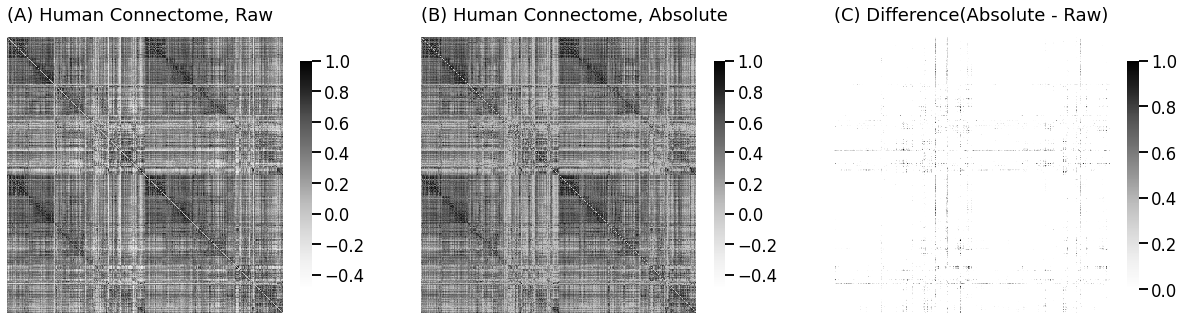

In [5]:
import matplotlib.pyplot as plt
from graphbook_code import heatmap

A_abs = np.abs(A)

fig, axs = plt.subplots(1,3, figsize=(21, 6))
heatmap(A, ax=axs[0], title="(A) Human Connectome, Raw", vmin=np.min(A), vmax=1)
heatmap(A_abs, ax=axs[1], title="(B) Human Connectome, Absolute", vmin=np.min(A), vmax=1)
heatmap(A_abs - A, ax=axs[2], title="(C) Difference(Absolute - Raw)", vmin=0, vmax=1)

In [6]:

from sklearn.base import TransformerMixin, BaseEstimator

class CleanData(BaseEstimator, TransformerMixin):

    def fit(self, X):
        return self

    def transform(self, X):
        print("Cleaning data...")
        Acleaned = remove_isolates(X)
        A_abs_cl = np.abs(Acleaned)
        self.A_ = A_abs_cl
        return self.A_

data_cleaner = CleanData()
A_clean = data_cleaner.transform(A)

Cleaning data...
Purging 0 nodes...


In [7]:
from graspologic.utils import binarize

threshold = 0.4
A_bin = binarize(A_clean > threshold)

In [8]:

from graspologic.utils import pass_to_ranks

A_ptr = pass_to_ranks(A_clean)

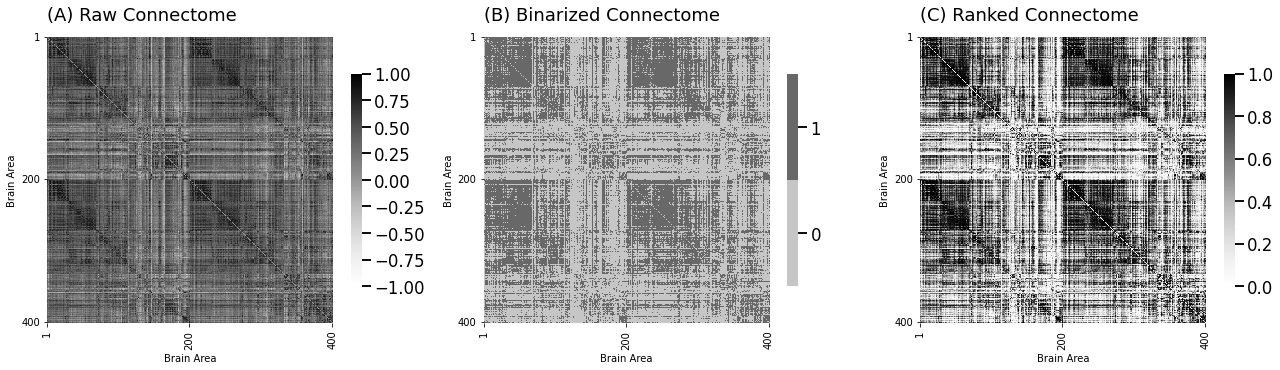

In [9]:
xtick = [0, 199, 399]; ytick = xtick
xlabs = [1, 200, 400]; ylabs = xlabs

fig, axs = plt.subplots(1,3, figsize=(18, 5))
heatmap(A, ax=axs[0], title="(A) Raw Connectome", vmin=-1, vmax=1, xticks=xtick, xticklabels=xlabs, 
        yticks=ytick, yticklabels=ylabs, xtitle="Brain Area", ytitle="Brain Area")
heatmap(A_bin.astype(int), ax=axs[1], title="(B) Binarized Connectome", xticks=xtick, xticklabels=xlabs, 
        yticks=ytick, yticklabels=ylabs, xtitle="Brain Area", ytitle="Brain Area")
heatmap(A_ptr, ax=axs[2], title="(C) Ranked Connectome", vmin=0, vmax=1, xticks=xtick, xticklabels=xlabs, 
        yticks=ytick, yticklabels=ylabs, xtitle="Brain Area", ytitle="Brain Area")
fig.tight_layout()


fname = "cleaning_connectomes"
if mode != "png":
    os.makedirs(f"Figures/{mode:s}", exist_ok=True)
    fig.savefig(f"Figures/{mode:s}/{fname:s}.{mode:s}")
    
os.makedirs("Figures/png", exist_ok=True)
fig.savefig(f"Figures/png/{fname:s}.png")

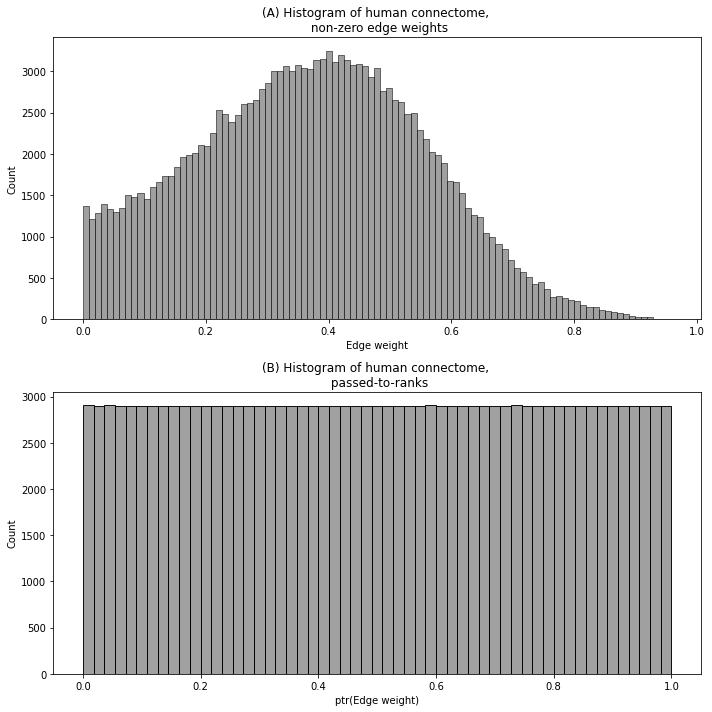

In [10]:
import seaborn as sns

fig, axs = plt.subplots(2,1, figsize=(10, 10))
sns.histplot(A_clean[A_clean > 0].flatten(), ax=axs[0], color="gray")
axs[0].set_xlabel("Edge weight")
axs[0].set_title("(A) Histogram of human connectome, \n non-zero edge weights")

sns.histplot(A_ptr[A_ptr > 0].flatten(), ax=axs[1], color="gray")
axs[1].set_xlabel("ptr(Edge weight)")
axs[1].set_title("(B) Histogram of human connectome, \n passed-to-ranks")
fig.tight_layout()

fname = "ptrhists"
if mode != "png":
    fig.savefig(f"Figures/{mode:s}/{fname:s}.{mode:s}")

fig.savefig(f"Figures/png/{fname:s}.png")

In [11]:
class FeatureScaler(BaseEstimator, TransformerMixin):
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        print("Scaling edge-weights...")
        A_scaled = pass_to_ranks(X)
        return (A_scaled)
    
feature_scaler = FeatureScaler()
A_cleaned_scaled = feature_scaler.transform(A_clean)
# Scaling edge-weights...

Scaling edge-weights...


In [12]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ('cleaner', CleanData()),
    ('scaler', FeatureScaler()),
])

A_xfm = num_pipeline.fit_transform(A)

Cleaning data...
Purging 0 nodes...
Scaling edge-weights...


In [13]:
A_xfm2 = num_pipeline.fit_transform(As[1])

Cleaning data...
Purging 0 nodes...
Scaling edge-weights...
